## Sentiment Analysis of Telecom Reviews

The problem I aimed to solve consists on determining the satisfaction of customers from the calling company Rebtel. 

The solution proposed relies on building a competitive model that predict the sentiment or rating an author gives in a review, which was posted in https://www.trustpilot.com.

The main process followed includes the next steps:

    1. Build a dataset containing the reviews and ratings posted in the website aforementioned.
    2. Evaluate the sentiment results provided by a lexicon selected.
    3. Build and validate different prediction models.
    4. Select the relevant metrics to compare prediction models.
    5. Determine main advantages and limitations of best model trained.
    6. Discuss the business implication of model built.


The dataset generated consists on a collection of reviews rated by their author. The rating varies from 1 to 5 stars; a 1-star review represents a customer not satisfied with Rebtel services, and a 5-star review represents a customer mostly satisfied with the Rebtel services. 

In a high-level explanation, I tried to solve a classification problem of 5 classes. In total, I built 3 predictor models that can learn to predict the class/rating of a given review. They are based in:

                1. Naive Bayes (NBC)
                2. Support Vector Machine (SVM)
                3. Random Forests Classifiers (RFC) and 
                4. Multi-Layer Perceptron (MLP)

Preprocessing of reviews and NLP techniques such as Ngram models and Lemmatization were used to build a useful bag-of-words, which were used to feed the predictor models. Four Performance metrics were used to evaluate the predictors. Approaches such as Greedy search and Cross-validation were taken into account to determine the optimal configuration of each model and secure their good generalization in data. 

The best model generated is the one based on a Multi-Layer Perceptron classifier with Precision of 62%, Recall of 60% and F-score of 60%. The best performance metrics obtained for each of the models built are the following:
        
            1. NBC predictor: Precision = 60%, Recall = 58% and F-score = 59%
            2. SVM predictor: Precision = 38%, Recall = 62% and F-score = 47%
            3. RFC predictor: Precision = 55%, Recall = 59% and F-score = 56%
            4. MLP predictor: Precision = 62%, Recall = 60% and F-score = 60%
            
            
            
Below it is explained in more depth steps mentioned at the beginning of this work.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.sentiment import vader
from Visual import Visualization as vs
from Visualization import Visualization
from imblearn.metrics import classification_report_imbalanced

## 1. Build dataset

The dataset was generated by scraping the reviews and any useful information related to the review. 

By the time data was obtained, the website (trustpilot.com) contained 2,111 reviews of Rebtel customers, which were posted since April 2011 until February 2017, and presented through 106 pages. 

The script written to get the data is based on the Beautifulsoup library. In summary, the process followed two steps. First, data related to each of the reviews such as rating, time of publication and so on was obtained. Then, for each review, specific information from the author/user like number of reviews posted and country was included. The resulting data was saved into the "rebtel.csv" file.

The set of information obtained contains the following fields:

    1.  Review. The review of the author
    2.  Title. The title of the review
    3.  Rating. The rate of the review
    4.  raw time. The time and date the review was posted
    5.  Country. The country where the author posted the review
    6.  Username. The name of the author
    7.  Reviews. The total number of reviews posted by the author
    8.  Reads. The number of persons that have read the review
    9.  Useful. The number of persons that found the review useful
    10. Genre. The genre of the author (if given)

       

In [3]:
raw_data = pd.read_csv('rebtel.csv')
p_data = pd.read_csv('rebtel_w_lexicon.csv')

In the original distribution of reviews per country (see plot below), we observe that most of the reviews come from the United States (~75%) or from English speaker countries. Then, I filtered and selected only those messages written in English. I took advantage of the "guess_language" library to predict whether a message was English-written. In countries like the United States many messages were written (for instance) in Spanish, and therefore, they were discarded from the dataset for the model.

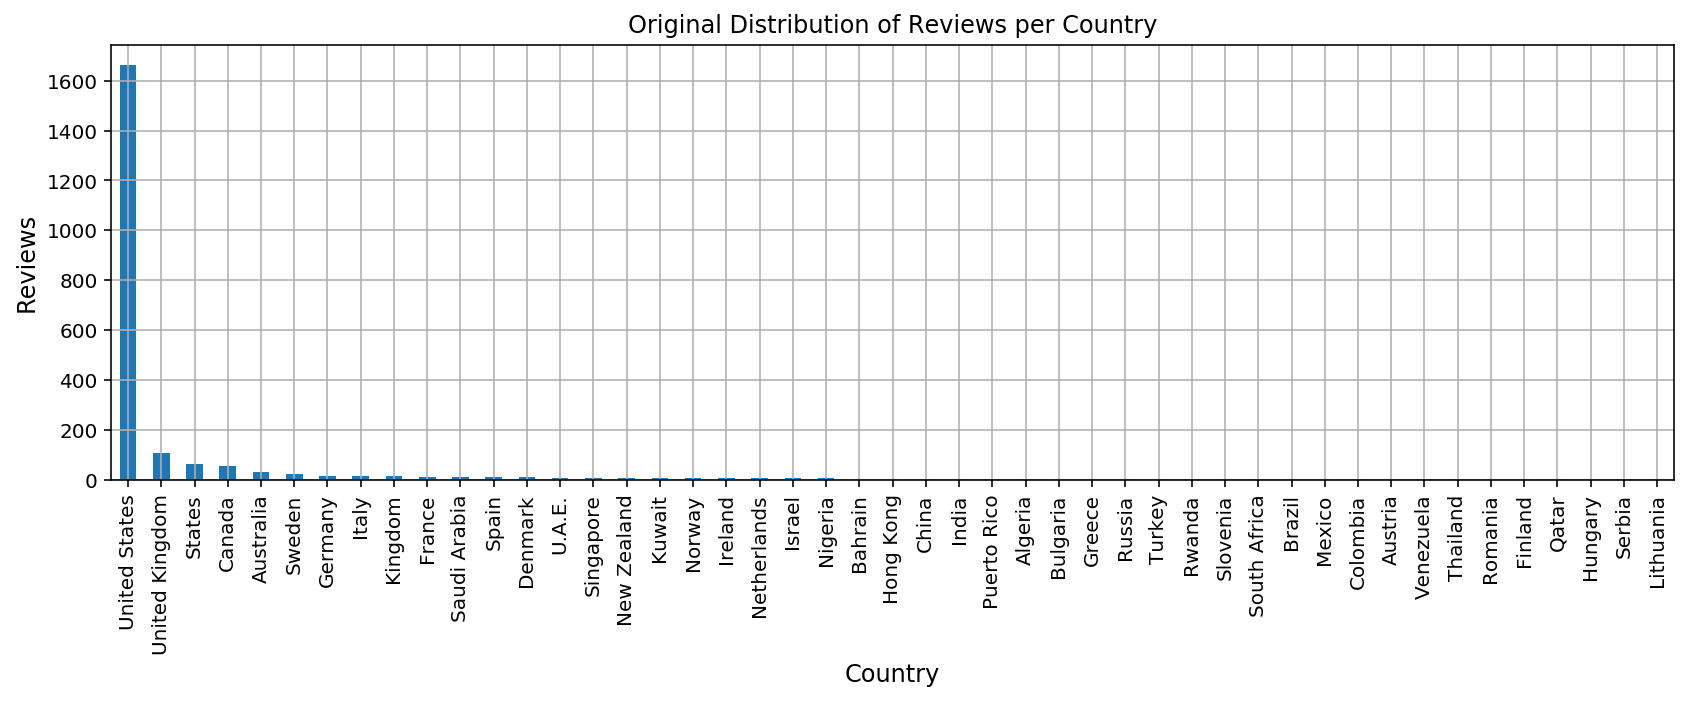

In [29]:
raw_data.Country.value_counts().plot(kind='bar',figsize=(14,4),grid=True,
                                     title="Original Distribution of Reviews per Country")

plt.ylabel('Reviews',size=12)
plt.xlabel('Country',size=12)
plt.show()

The distribution of Reviews used for building the models is shown below. As observed, the most significant reduction of reviews is observed in the US with around 200 reviews ommited. However, for most of the countries there are very few samples of reviews meeting the English language condition.

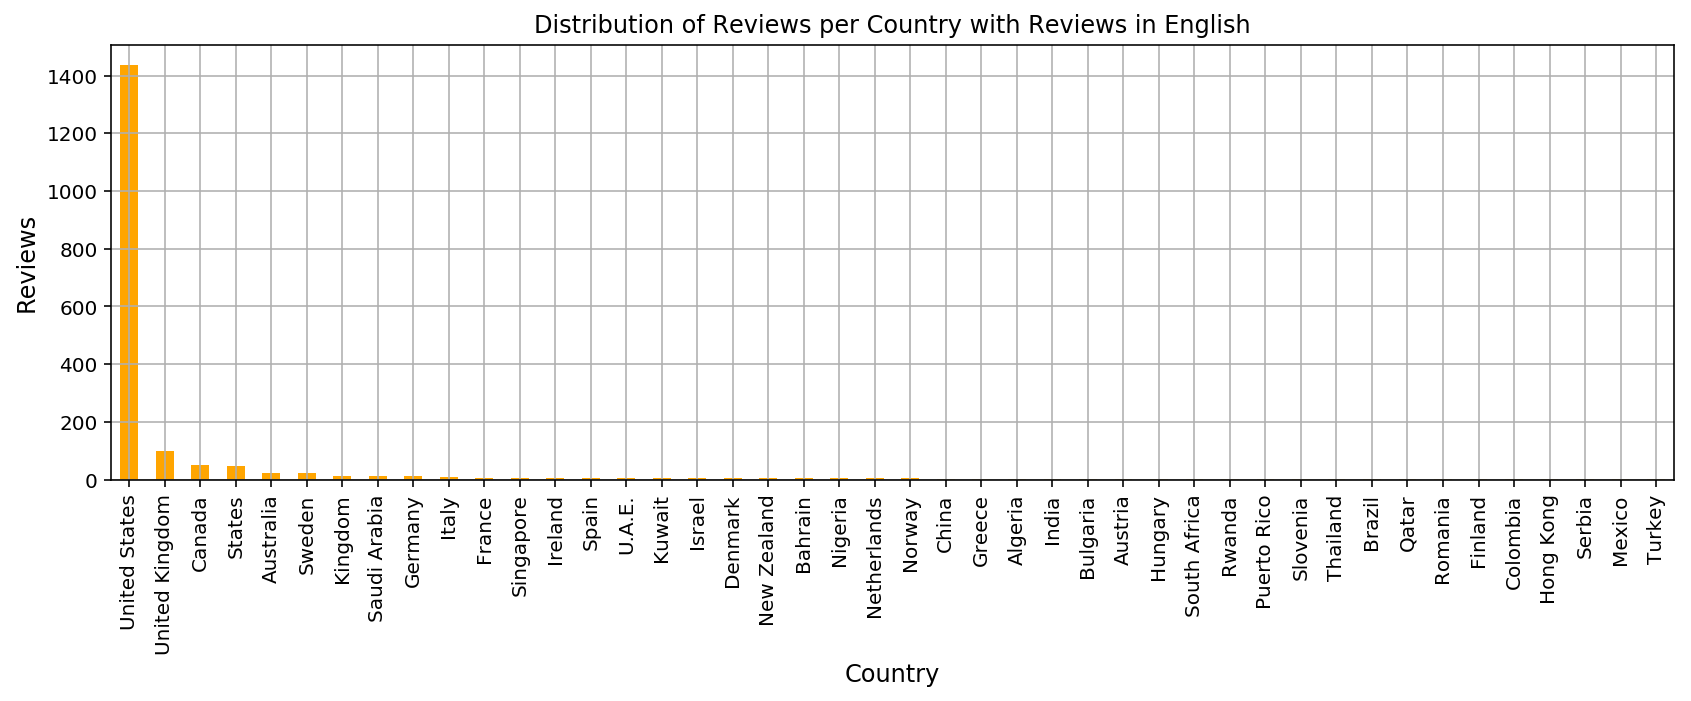

In [10]:
p_data.Country.value_counts().plot(kind='bar',figsize=(14,4),grid=True,
                                     title="Distribution of Reviews per Country with Reviews in English",
                                  color='orange')

plt.ylabel('Reviews',size=12)
plt.xlabel('Country',size=12)
plt.show()

The distribution of reviews per rating in the dataset is imbalanced. As observed below, the ratio of class 5 (the most populated class) over class 2 (the least popular class) is 8:1 approximately. Dealing with imbalanced classes was one of the major problems I dealt with, when trying to build this sentiment predictor. Based on that, we could expect that the classifiers perform poorly with classes 2 and 3, which are the least populated classes, as well as having high accuracy with samples of class 5. Similarly, classifiers might confuse unseen reviews with the most populated class (i.e. rating 5) if techniques to deal with imbalanced classes are not considered during the training stage.

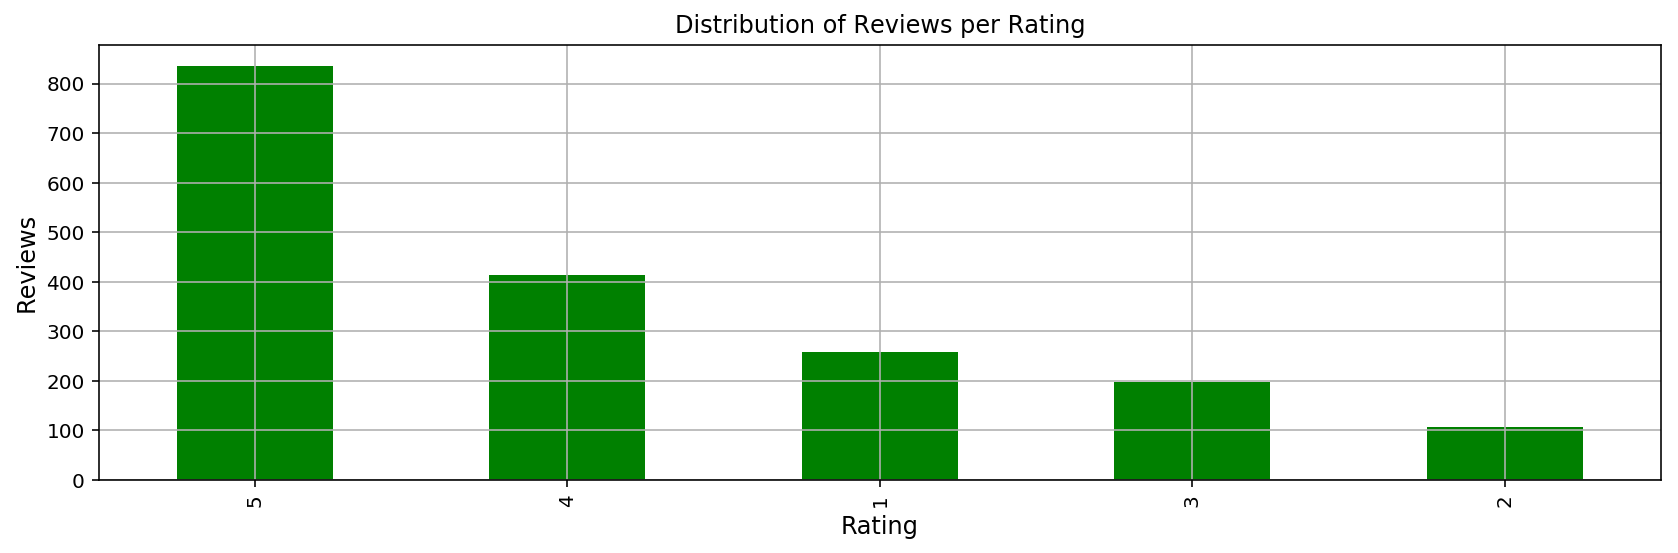

In [22]:
p_data.Rating.value_counts().plot(kind='bar',figsize=(14,4),grid=True,
                                     title="Distribution of Reviews per Rating",
                                  color='green')
plt.ylabel('Reviews',size=12)
plt.xlabel('Rating',size=12)
plt.show()

# 1.1 Preprocessing of data

The raw reviews contain a title and a review that are useful to feed our models. They were cleaned and preprocessed using diverse considerations. For instance, unlike standard preprocessing of text, I did not remove some punctuation and numbers contained because they can carry some sentiment of the review, and then, I treated them as words. On the one side,  any number was replaced with the placeholder word "NUM"; if the number was preceded or followed by any character such as $, £ or €, the number and the character were substituted by "PRICE". The name of the company Rebtel was changed by "COMPANY". On the other side, characters such as "!!!" or "..." also carry and emphasize some sentiment, mainly, of frustration or anger in reviews with ratings of 1 and 2. They were also considered and not removed in comparisson to other characters such as "," or ".".

The word NOT typically carried a negative sentiment in reviews. In order to keep that sentiment, when a negation word such as NOT, NEVER or NEITHER was detected, the following word was modified and the character "!" was added to it. For instance when having "not nice", the resulting review was "!nice". The purpose of this alteration was made to help (for instance) unigram models to keep the negative sentiment contained in a message.

Similarly, raw data contained several typos and I used a spelling checker (written by mattalcock https://github.com/mattalcock/blog/blob/master/2012/12/5/python-spell-checker.rst), which was in charge of writing correctly as much misspelling words as possible. Initially, it had some limitations and used to modify important words that carried a positive or negative sentiment, even when they were written properly. For example, words like "cheap" and "big" were changed by "heap" and "fig". A lexicon including the most important positive and negative words was used on top of the spelling checker, and then, only "neutral" words were checked/modified by the spelling checker. This reduced the mistakes made by the checker and reviews were cleaned more properly as important implicit sentiments of relevant words remained in the message.



In [30]:
print("This is an instance of the raw data: \n","Review : ",raw_data["Review"][0],
     "\n Title : ", raw_data["Title"][0])

This is an instance of the raw data: 
 Review :  Rebtel I had been charged several times even when the phones are not connected. 419 in phone clothing 
 Title :  Charged without connetion


In [31]:
print("This is the same instance preprocessed: \n","Review : ",p_data["Rel_w_review"][0],
     "\n Title : ", p_data["Rel_w_title"][0])

This is the same instance preprocessed: 
 Review :  COMPANY charged several times even phones not !connected  NUM phone clothing 
 Title :  charged without connection


Different techniques of Lemmatization and Stemming were performed in the reviews. Three different stemming approaches were considered: 1) Lancaster Stemming 2) Porter Stemming and 3) Snow Stemming. Each of these four techniques -the lemmatization and the 3 sorts of stemming- were used separately and compared when feeding the models, as each of them 
had a different impact on each of the predictor models. An example is that Lancaster proved to be more informative for the SVM models than for RFC models. 

Finally, the normalized text from the title and review were merged to conform a unique message that was used to build a useful bag-of-words.

Below there is an example of the original raw data, followed by the preprocessed data obtained.

In [32]:
print("This is the same instance with title and review merged: \n","Review : ",p_data["Rel_w_title_review"][0])

This is the same instance with title and review merged: 
 Review :  charged without connection COMPANY charged several times even phones not !connected  NUM phone clothing


## 2. VADER-Sentiment-Analysis (Lexicon Evaluation)

After that, I used the VADER-Sentiment-Analysis, which is a lexicon and rule-based sentiment analysis tool. It can be found in: https://github.com/cjhutto/vaderSentiment. I decided to select the VADER among other lexicons such as the SENTLEX lexicon (http://kmandcomputing.blogspot.nl/2014/09/a-lexicon-based-sentiment-classifier-in.html) because VADER is attuned to sentimens expressed in social media. It incorporates (for example) word-order sensitive relationships between terms. It is capable of understand sentiment-laden slang words (e.g. "sux" or "kinda"), it is sensitive to usage of punctuation that increases sentiment intensity (e.g. "Good!!!"), as well as it was also built using data from reviews of movies and Amazon products. Therefore, these features and the robustness of the Lexicon make the VADER an interesting tool to evaluate the sentiment of Rebtel's reviews.

The VADER lexicon provides an unidimensional and multidimensional measures of sentiment for a given sentence. The unidimensional measure (called "compound") provides a normalized value between -1 (most extreme negative) and +1 (most extreme positive). The "pos", "neu" and "neg" scores are the multidimensional ratios for proportions of text that fall in each category. 

Sentiment Analysis using VADER was performed for each of the reviews included in the cleaned dataset. Each of the reviews included was analyzed only with the substitution of numbers, prices and company's name, due to VADER is sensitive to word-order relationships and punctuation marks. This word substitution helped the Lexicon to deal with unknown words like "Rebtel", and consequently, improved in some cases accuracy of measures for sentiment analysis.

In most of the cases, the VADER lexicon provided a fair performance when predicting the sentiment of the reviews. 
Adjectives typically helped the lexicon to determine the sentiment of a message. For instance, "reliable" is an example of an indicator that Lexicon considered to determine positiveness of a message. Equally, words like "worst" are clearly identified and they influence the negativeness of the score predicted by the Lexicon.




In [35]:
v = vader.SentimentIntensityAnalyzer()
message = p_data["Num_inc_title"][40]
print("The positive title of a review is: ", message)
print("Its score is mainly positive: ",v.polarity_scores(message))

The positive title of a review is:  Great service
Its score is mainly positive:  {'compound': 0.6249, 'pos': 0.804, 'neg': 0.0, 'neu': 0.196}


In [36]:
message = p_data["Num_inc_title"][70]
print("The negative title of a review is: ", message)
print("Its score is mainly negative: ",v.polarity_scores(message))

The negative title of a review is:  Worst company and customer service
Its score is mainly negative:  {'compound': -0.6249, 'pos': 0.0, 'neg': 0.506, 'neu': 0.494}


As expected, one of the limitations of the Lexicon is that it cannot handle misspelled words/reviews. Below is observed that misspellings words such as  "Theives!!!!" are hard to detect, and then they are mostly scored with a "Neutral" sentiment. Oppositely, the corrected message "Thieves!!!!" is properly scored with a "Negative" sentiment. 

In [39]:
message = raw_data["Title"][28]
print("The misspelled title of the review is: ", message)
print("Its score is neutral: ",v.polarity_scores(message))

The misspelled title of the review is:  Theives!!!!
Its score is neutral:  {'compound': 0.0, 'pos': 0.0, 'neg': 0.0, 'neu': 1.0}


In [41]:
message = p_data["Num_inc_title"][70]
print("The corrected title of the review is: ", message)
print("Its score is mostly negative: ",v.polarity_scores(message))

The corrected title of the review is:  Worst company and customer service
Its score is mostly negative:  {'compound': -0.6249, 'pos': 0.0, 'neg': 0.506, 'neu': 0.494}


Similarly, the lenght and structure of a review play an important role when predicting its sentiment. As observed below most of the text is categorized as neutral, and therefore, the genuine negative sentiment is vanished.

In [43]:
message = raw_data["Review"][28]
print("The message of the review is: ", message)
print("Its score is mainly neutral: ",v.polarity_scores(message))

The message of the review is:  My first 600 minutes were supposed to be free!. Now I've been charged $45 in a course of three months for what???. Please uninstall this app, you are better off with google voice/whatsapp...or anything!!. URGH!! I'm soooo mad!!!!!
Its score is mainly neutral:  {'compound': 0.7276, 'pos': 0.162, 'neg': 0.042, 'neu': 0.796}


After evaluating the VADER Lexicon, with the mean values and standard deviation obtained for each rating class, I built a simple predictor, whose metrics are: precision of 48%, recall of 48% and F-score of 46%. 

The confusion matrix below shows two important confusions made by the Lexicon. One focuses in the negative classes (Ratings 1 and 2) and the other one focuses in the positive sentiment (Classes 4 and 5). Nevertheless, the most difficult class to predict for the model was the neutral sentiment, which is confused most of the times with any of the possible classes.

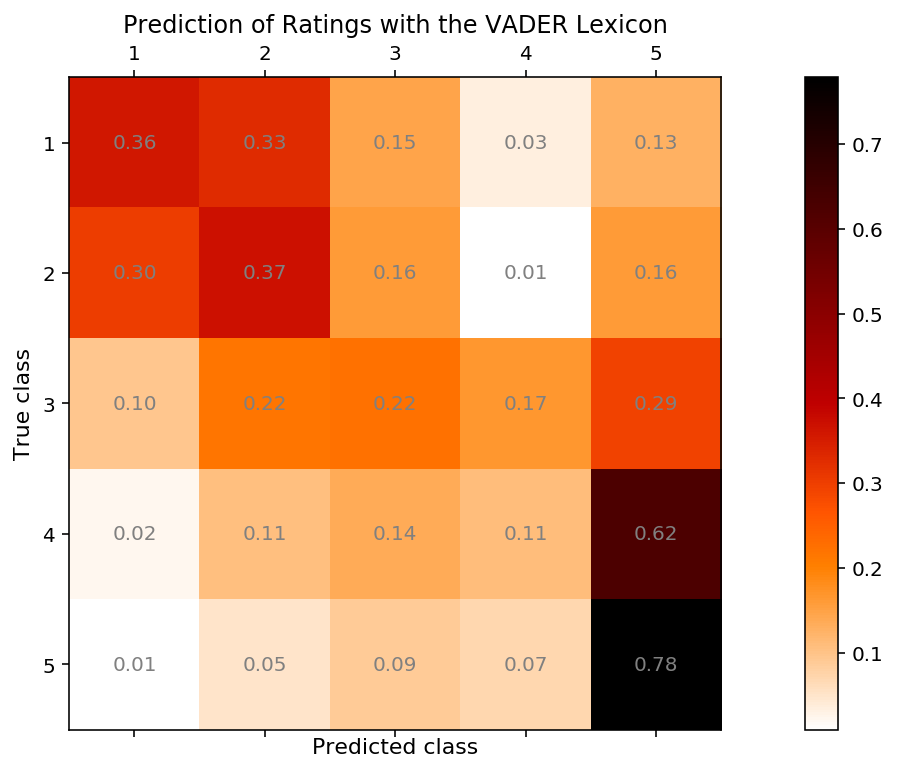

In [44]:
vis.plot_confusion_matrix(p_data['Rating'], p_data['Lex_preds'], 
                          'Prediction of Ratings with the VADER Lexicon',normalize=True)

In [45]:
print("The performance metrics of the VADER Lexicon predictor are: \n",
    classification_report_imbalanced(y_pred=p_data['Lex_preds'],y_true=p_data['Rating']))

The performance metrics of the VADER Lexicon predictor are: 
                    pre       rec       spe        f1       geo       iba       sup

          1       0.57      0.36      0.95      0.44      0.71      0.49       258
          2       0.15      0.37      0.87      0.22      0.38      0.14       106
          3       0.19      0.22      0.88      0.21      0.42      0.16       197
          4       0.31      0.11      0.93      0.16      0.49      0.23       414
          5       0.64      0.78      0.62      0.70      0.70      0.48       836

avg / total       0.48      0.48      0.78      0.46      0.60      0.37      1811



## 3. Sentiment predictor models

The four models built were proposed based on their complexity and their common implementation on sentiment analysis classification. The approach taken was building the simplest model and trained more complex models after finding a maximum area of convergence with data. 

The attributes used to train all of the models were built using a bag-of-words representation. Term frequency and Tf-idf vectors were tested separately to determine which one of them brought a better representation of the reviews. Unigram and bigram models were also considered when building each of the bag-of-words representations. These bag-of words were constructed for the reviews normalized with a Lemmatization or any of the Stemming techniques, and the one with the best performance for each model was selected. In most of the cases the Lancaster Stemming  was the most useful technique for most of the models.  

Additional features such as the compound scores obtained from the VADER lexicon complemented the bag-of-words vectors. Similarly, other relevant attributes that can be correlated to to the classes of reviews like the Country and the number of Reads from a given review were included to feed each of the models. After that, PCA was used for two purposes: 1)To find the main (i.e. the most representative) features of the data and  2)To reduce the curse of dimensionality. When using PCA, the principal 150 attributes resulting from this technique proved to be the most useful set of attributes to feed the main models.

Imbalanced classes was one of the major problems when training the models; it caused a poor classification performance in all of the trained models. To deal with it techniques such as weigthed samples and oversampling were used when (or before) training each of the models. Weighted samples showed a slightly improvement in performance of classification models. Nevertheless, oversampling affected the performance of all of the models. In each case, despite oversampling showed a very high performance during the training and cross-validation steps, the trained models showed the worst performance when tested with unseen data. After realizing this, oversampling was not considered anymore as synthetic samples did not lead to a solution for this imbalanced classes.

Greedy Search and Cross-validation were two important techniques used during the training stage. First, a Greedy search was performed to determine a potential area of convergence for the models, and find the optimal set of parameters of the classifiers trained. Cross-validation was also considered with the purpose of avoiding overfitting. In addition, bagging techniques were implemented to help the model learning a good generalization of the data when testing the model with unseen data.


The main metrics selected to evaluate and compare each of the models are Precision, Recall and F-score. These metrics were considered instead of the traditional classification accuracy, as they can provide a major understanding of the performance of the model. Accuracy was not considered as part of the evaluation, as this metric can provide a non-genuine description of the classification performance if classes are imbalanced, which is the case of this problem. Then, I tried to balance the Precision, Recall and F-score metrics when possible, although Precision was prioritized over Recall and F-score in extreme cases, where most of these metrics had very similar scores. 


Finally, despite all of these powerful techniques were considered to build a robust model. The performance obtained in all of the cases was not as competitive as expected. There are diverse reasons of why the performance of the model is not performing well enough. One of the main reasons might be caused by the quality of the training corpus. As data contains human entries, it is likely that some ambiguities in reviews are observed: making very hard for any model to define a solid description of a given class, which can also diferentiate each of the classes form the others. A good solution for that could be to curate manually the training dataset. This alternative can help to disambiguate potential relationships between classes, which can be intractable for the algorithms, and which prevent the models to have a better understanding of the classes in the corpus. Similarly, by introducing new content from this curation we can help the models to explore new relationships that describe more accurately each of the classes given.


Another cause of the performance involves the complexity of the language itself, which is constantly modified by idioms and neologisms. Then this sparsity in the structure of language and the manner people express their sentiments is more complex than the knowledge contained in the training corpus. A solution to tackle this issue could be to include additional reviews, which could help the classifiers to learn a better generalization by feeding them with more useful information of the reviews.



# 3.1 Naive Bayes Classifier

The performance of the Naive Bayes Classifier positioned this model as one of the best model to use for the classification task required. Despite the simplicity of this algorithm, this model proved to be one of the best to differentiate between very positive and negative sentiments. However, some of the limitations of this model were found when trying to classify reviews with a neutral or a semi-negative sentiment.

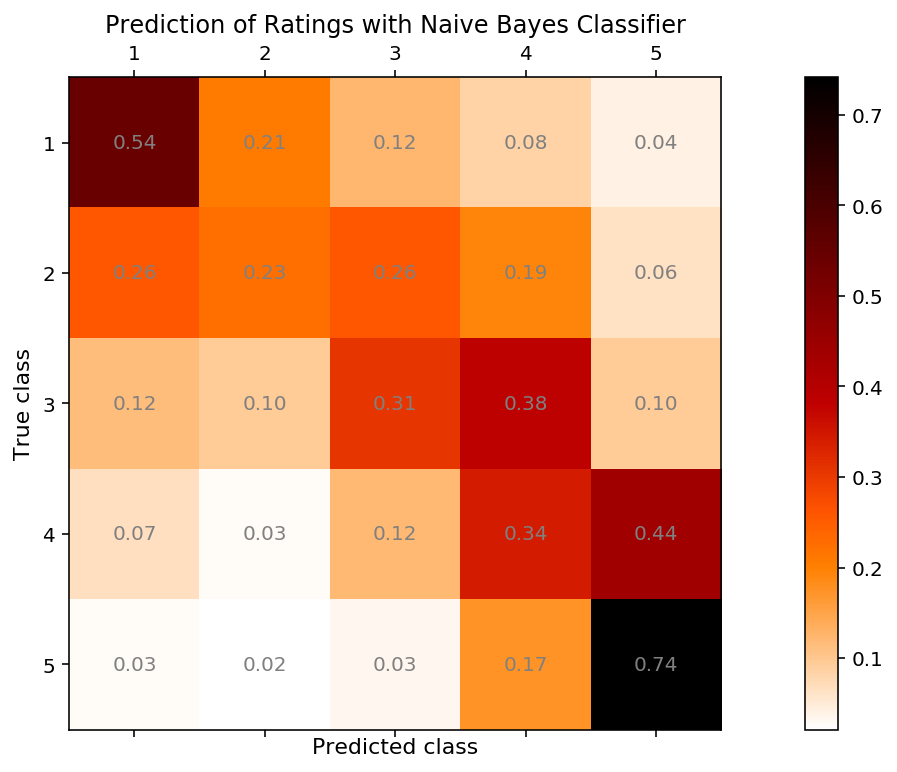

In [93]:
nb_data = pd.read_csv('NB_predictions.csv')

vis.plot_confusion_matrix(nb_data['True_label'], nb_data['NB_pred'], 
                          'Prediction of Ratings with Naive Bayes Classifier',normalize=True)

In [94]:
print("The performance metrics of the Naive Bayes predictor are: \n",
    classification_report_imbalanced(nb_data['True_label'], nb_data['NB_pred']))

The performance metrics of the Naive Bayes predictor are: 
                    pre       rec       spe        f1       geo       iba       sup

          1       0.27      0.54      0.94      0.36      0.52      0.25        24
          2       0.24      0.23      0.96      0.23      0.48      0.22        31
          3       0.28      0.31      0.93      0.29      0.51      0.24        52
          4       0.35      0.34      0.81      0.35      0.53      0.27       148
          5       0.79      0.74      0.71      0.77      0.72      0.52       379

avg / total       0.60      0.58      0.77      0.59      0.64      0.42       634



In [95]:
print("Accuracy of NB classifier: ", np.mean(nb_data['True_label'] == nb_data['NB_pred'])*100, " %")

Accuracy of NB classifier:  58.0441640379  %


# 3.2 Support Vector Machine

Support Vectorm Machine had the poorest performance. It was very difficult for this model to learn any relevant information that didn't corrrespond to the class 5. Then, the behaviour of this model demonstrate its preference for predicting any review observed as the class that contained more examples in the training data. The model was very slow to be trained and the results obtained weren't as competitive as expected.


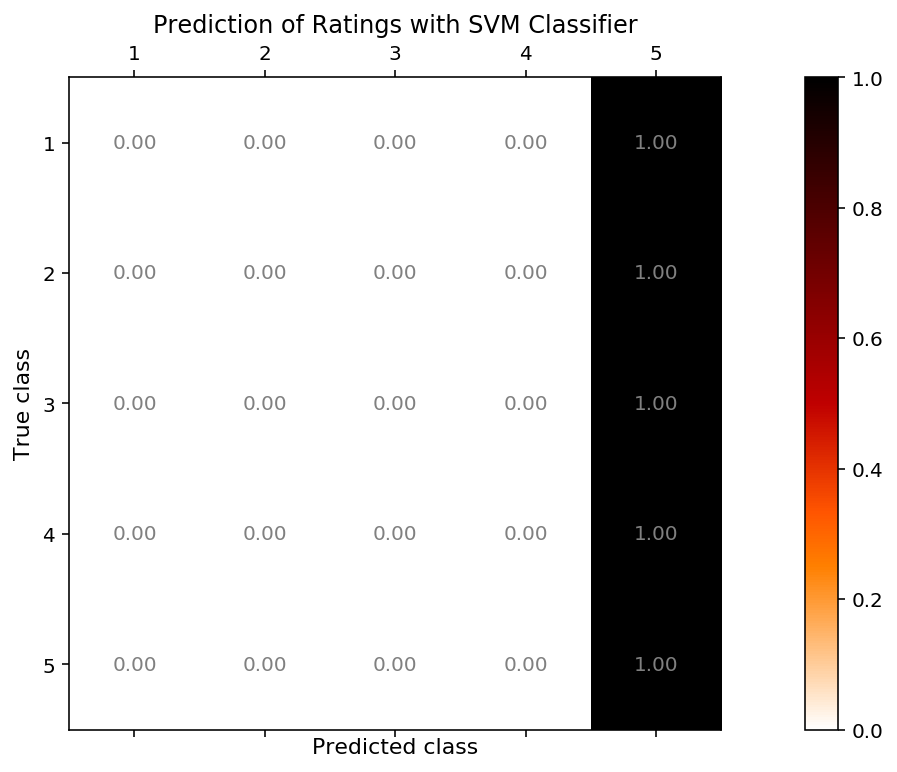

In [61]:
svm_data = pd.read_csv('SVM_predictions.csv')

vis.plot_confusion_matrix(svm_data['True_label'], svm_data['SVM_pred'], 
                          'Prediction of Ratings with SVM Classifier',normalize=True)

In [63]:
print("The performance metrics of the SVM predictor are: \n",
    classification_report_imbalanced(svm_data['True_label'], svm_data['SVM_pred']))

The performance metrics of the SVM predictor are: 
                    pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00        18
          2       0.00      0.00      1.00      0.00      0.00      0.00        15
          3       0.00      0.00      1.00      0.00      0.00      0.00        42
          4       0.00      0.00      1.00      0.00      0.00      0.00       127
          5       0.62      1.00      0.00      0.76      0.00      0.00       326

avg / total       0.38      0.62      0.38      0.47      0.00      0.00       528



/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/Users/rcortez/anaconda/envs/python3/lib/python3.5/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


In [70]:
print("Accuracy of NB classifier: ", np.mean(svm_data['True_label'] == svm_data['SVM_pred'])*100, " %")

Accuracy of NB classifier:  61.7424242424  %


# 3.3 Random Forest Classifier

RFC was one of the models with better metrics performance. However, when evaluating the results visually it is clear that the model built makes strong assumptions which are reflected in the missclasification of reviews as very positive or very negative. A clear example of this behavior is observed in class 3 where neutral reviews were categorized either as positive or negative, but very few times this messages were correctly classified as neutral (or class 3).

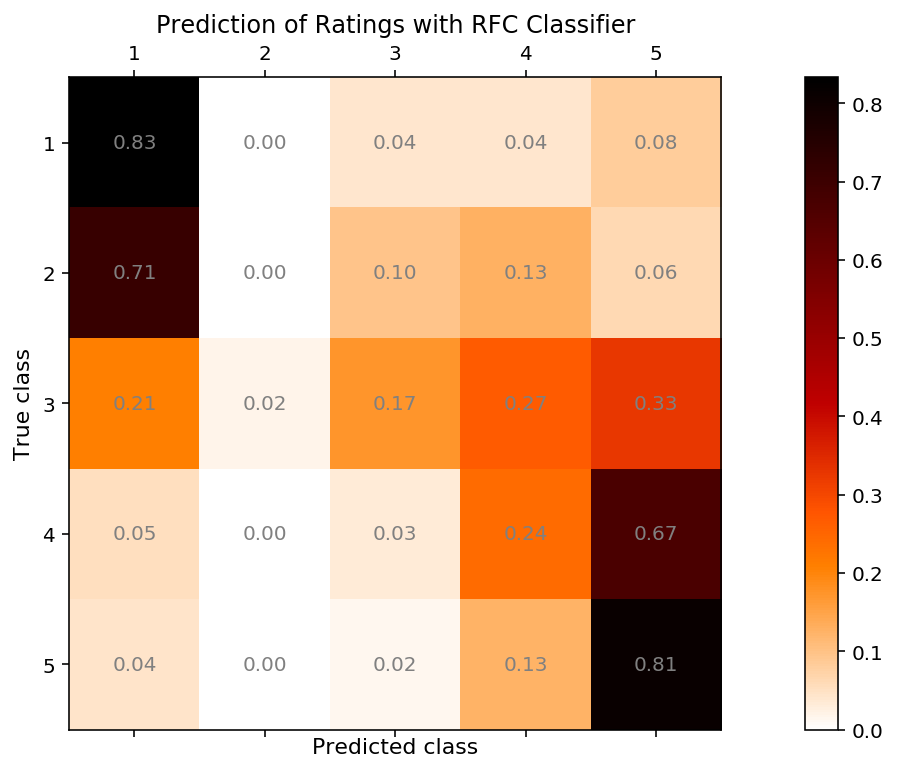

In [97]:
rfc_data = pd.read_csv('RFC1_predictions.csv')

vis.plot_confusion_matrix(rfc_data['True_label'], rfc_data['RFC_pred'], 
                          'Prediction of Ratings with RFC Classifier',normalize=True)

In [88]:
print("The performance metrics of the RFC predictor are: \n",
    classification_report_imbalanced(rfc_data['True_label'], rfc_data['RFC_pred']))

The performance metrics of the RFC predictor are: 
                    pre       rec       spe        f1       geo       iba       sup

          1       0.26      0.83      0.90      0.39      0.50      0.24        24
          2       0.00      0.00      1.00      0.00      0.00      0.00        31
          3       0.38      0.17      0.97      0.24      0.59      0.33        52
          4       0.35      0.24      0.86      0.29      0.53      0.26       148
          5       0.72      0.81      0.53      0.76      0.69      0.47       379

avg / total       0.55      0.59      0.68      0.56      0.60      0.38       634



In [89]:
print("Accuracy of RFC classifier: ", np.mean(rfc_data['True_label'] == rfc_data['RFC_pred'])*100, " %")

Accuracy of RFC classifier:  58.832807571  %


# 3.4 Multi-Layer Perceptron

The model that presented a better generalization of the data was the MLP model, which as observed below, was able to capture different information that characterizes each of the classes. Based on the results, it was very difficult to fool the model when classifying neutral reviews. However, when classifying negative or positive reviews it shows a tendency for confusing reviews with extreme emotions like cases where class 2 was missclasified as class 1 and class 4 was missclasified with class 5.

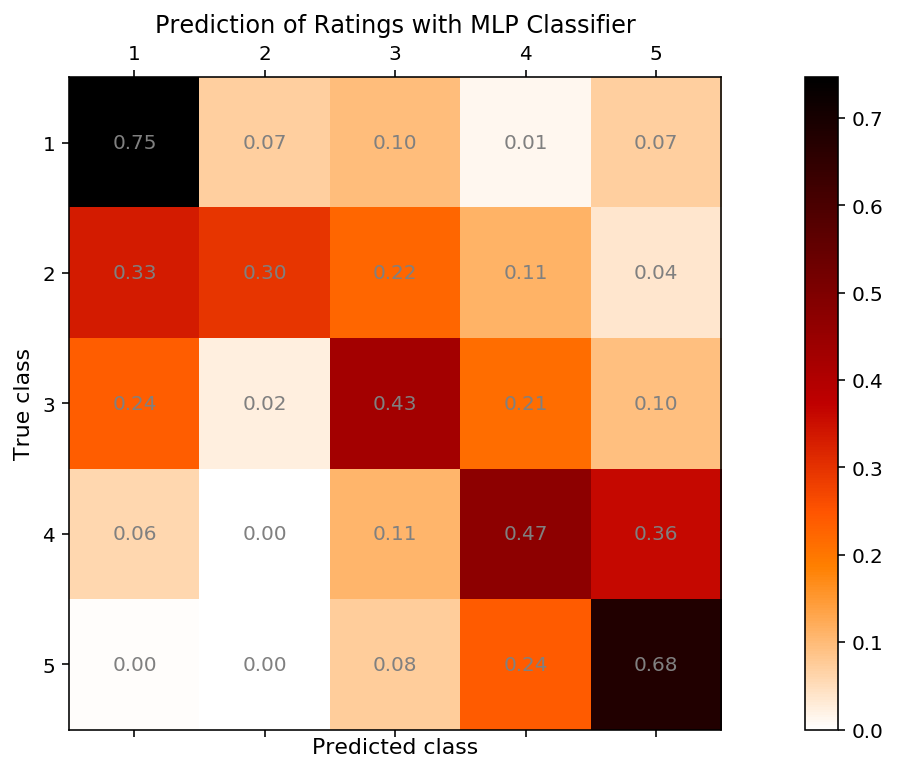

In [84]:
mlp_data = pd.read_csv('MLP_predictions.csv')

vis.plot_confusion_matrix(mlp_data['True_label'], mlp_data['MLP_pred'], 
                          'Prediction of Ratings with MLP Classifier')

In [85]:
print("The performance metrics of the MLP predictor are: \n",
    classification_report_imbalanced(mlp_data['True_label'], mlp_data['MLP_pred']))

The performance metrics of the MLP predictor are: 
                    pre       rec       spe        f1       geo       iba       sup

          1       0.67      0.75      0.93      0.71      0.80      0.62        71
          2       0.57      0.30      0.99      0.39      0.74      0.53        27
          3       0.31      0.43      0.90      0.36      0.54      0.27        42
          4       0.42      0.47      0.82      0.45      0.60      0.34       100
          5       0.76      0.68      0.81      0.72      0.75      0.56       213

avg / total       0.62      0.60      0.85      0.60      0.70      0.49       453



In [86]:
print("Accuracy of MLP classifier: ", np.mean(mlp_data['True_label'] == mlp_data['MLP_pred'])*100, " %")

Accuracy of MLP classifier:  59.8233995585  %


# 4. Business Implications

Sentiment Analysis is becoming an essential tool for companies in areas where they are in direct contact with their customers. It provides a hollistic understanding of the stages involved in the customer experiences. Unlike other aspects, the success of a company relies mainly on the satisfaction of customers with the services a company is offering. Typically, positive sentiments from users in a service are positively correlated with the engagement of them with the company. Then, it is reasonable to think that by enhancing customer satisfaction, in their various ways, we could directly strenghten the participation and growth of our company.

In many cases, metrics like daily sales or estimations such as retention or life time value of customers are aspects that play an important role in the decisions made by a company, because they provide an estimation of how well is a company or a service in the market. This metrics together with sentiment analysis models can provide a broader knowledge of the participation of our company in the market. Sentiment analysis models can help getting a better answers like how our users are, and what perception they have from our company. This can be very helpful since it allows to elaborate a market strategy which impacts strategically on key aspects for our customers, which can lead to a more successful satisfaction of customers.

A sentiment analysis (SA) model, like the one I built, allows companies to build better applications that interact directly with people, and most importantly, that satisfy customer expectations, by having a more genuine understanding of their needs. Always areas like customer services and marketing require tremendous efficiency to impact positively in the users. By identifying whether a customer is happy or disapointed with these SA models, we could take actions that amaze them. Wouldn't it be nice to have a more interactive and efficient customer service that provides straightforward solutions when necessary or that encourage a good message from a happy customer? 

These models can be updated constantly, and they can be able to detect market dynamics like detecting regions where users are facing problems with our service. If we are tracking the traffic in our social media platforms, and we segmentate our market by countries or regions, we could evaluate the ratio of positive versus negative reviews as well as the current behaviour of reviews in comparison to previous or historical days.

Moreover, theese sentiment analysis models can be extended to perform other tasks such as identifying the trends in our social media, and for the case of our competitors, it is also possible to evaluate how is our performance in comparison to them, and discover through the analysis of the sentiment and the contain of the reviews, strategies that could strengthen our position in the market.

At the end, the potential of sentiment analysis models relies on dimishing the challenge of understanding the evolution and expectations of our customers. Taking advantage of these models provide powerful insights that many times are required to make better decisions in our business strategy. Then, focusing on the detection and promotion of positive emotions, we could directly impact on loyalty of customers, which is one of the key characteristics of the main fastest growing companies in the market.
